# **Pronóstico del SARS-CoV-2 en Colombia**

**Presentado por:**


1.   Diego Alejandro Castaño Montoya
2.   Juliana Ceballos Peña
3.   Wilmar Stiven Sanchez Muñoz
4.   Laura María Yarce Gomez 

En este proyecto se puede encontrar pronósticos de la enfermedad Covid-19 referentes a nuevos casos, casos activos, recuperados y fallecidos en cinco ciudades principales de Colombia: Bogotá, Barranquilla, Cartagena, Cali y Medellín, estas ciudades fueron escogidas por ser principalmente las que reportaban más casos. Los pronósticos se desarroll con base en la información publicada por el gobierno en www.datos.gov.com, información de uso público.


In [ ]:
pip install statsmodels --upgrade

     |████████████████████████████████| 9.5MB 2.6MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


# Carga paquetes necesarios 

In [ ]:
# Paquetes
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import datetime
from datetime import date, timedelta
import numpy as np
from pylab import rcParams
from datetime import date
import pytz 

# modelos corto plazo
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults 
from sklearn.metrics import mean_squared_error
# modelo largo plazo
from scipy.integrate import odeint

# Conexión fuente de información y lectura de datos

In [ ]:
df = pd.read_csv('https://www.datos.gov.co/api/views/gt2j-8ykr/rows.csv?accessType=DOWNLOAD&bom=true&format=true')

# pasar a minuscula
df.columns  = map(str.lower, df.columns) # volver minuscula las columnas
df['estado'] = df['estado'].str.lower()
df['atención'] = df['atención'].str.lower()
df['pertenencia etnica'] = df['pertenencia etnica'].str.lower()
df['sexo'] = df['sexo'].str.lower()
df['ciudad de ubicación'] = df['ciudad de ubicación'].str.lower()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10,12,14,16,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Limpieza y preprocesamiento

In [ ]:
# Organizar fechas
fechas = ['fecha de notificación','fecha diagnostico','fis','fecha de muerte','fecha recuperado','fecha reporte web']

for i in range(len(fechas)):
  df[fechas[i]] = df[fechas[i]].apply(lambda x: str(x)[0:4]+'-'+str(x)[5:7]+'-'+str(x)[8:10]) # quitar hora de la fecha y convertir en formato
  df[fechas[i]] = pd.to_datetime(df[fechas[i]], format = '%Y-%m-%d', errors='coerce' ) # convertir a formato fecha

In [ ]:
# Remplazar valores
df['atención'] = df.apply(lambda x: 'casa' if pd.isnull(x['atención']) and pd.notnull(x['estado']) else x['atención'], axis =1)
df['fecha diagnostico'].fillna(df['fecha de notificación'], inplace = True)
df['fis'].fillna(df['fecha de notificación'], inplace = True)

In [ ]:
fis_f = df[df['atención']=='fallecido'].groupby(['ciudad de ubicación','fecha de muerte'])[['id de caso']].count().reset_index() # fallecidos
fis_r = df[df['atención']=='recuperado'].groupby(['ciudad de ubicación','fecha recuperado'])[['id de caso']].count().reset_index() # recuperados
fis_n = df.groupby(['ciudad de ubicación','fis'])[['id de caso']].count().reset_index()# nuevos

In [ ]:
# crear columna con todas las fechas desde la minima hasta la maxima fecha
df2 = pd.DataFrame(pd.date_range(start=df['fis'].min()+ datetime.timedelta(days=0), end= df['fis'].max())- datetime.timedelta(days=0)).rename(columns = {0:'fecha'})

# crear lista de ciudades
lista = ['bogotá d.c.','medellín','barranquilla','cartagena de indias', 'cali']

In [ ]:
# agregar información por ciudad en la fecha fis
for i in lista:
  df2 = pd.merge(df2, fis_f[fis_f['ciudad de ubicación'] == i][['fecha de muerte','id de caso']], how ='left', left_on ='fecha', right_on = 'fecha de muerte').drop('fecha de muerte', axis = 1).rename(columns ={'id de caso': str(i)[0:3] + '_f'})
  df2 = pd.merge(df2, fis_r[fis_r['ciudad de ubicación'] == i][['fecha recuperado','id de caso']], how ='left', left_on ='fecha', right_on = 'fecha recuperado').drop('fecha recuperado', axis = 1).rename(columns ={'id de caso': str(i)[0:3] + '_r'})
  df2 = pd.merge(df2, fis_n[fis_n['ciudad de ubicación'] == i][['fis','id de caso']], how ='left', left_on ='fecha', right_on = 'fis').drop('fis', axis = 1).rename(columns ={'id de caso': str(i)[0:3] + '_n'})

In [ ]:
### sacar acumulado
df3 = df2.copy()

## lista columnas actuales
lista_n = ['bog_n','med_n','bar_n','car_n','cal_n']
lista_r = ['bog_r','med_r','bar_r','car_r','cal_r']
lista_f = ['bog_f','med_f','bar_f','car_f','cal_f']

## lista columnas nuevas

# casos activos
lista_a = ['bog_a','med_a','bar_a','car_a','cal_a'] 

# casos acumulados
lista_ca = ['bog_ca','med_ca','bar_ca','car_ca','cal_ca']
lista_ra = ['bog_ra','med_ra','bar_ra','car_ra','cal_ra']
lista_fa = ['bog_fa','med_fa','bar_fa','car_fa','cal_fa']

# promedio movil
lista_prom_n = ['bog_prom_n','med_prom_n','bar_prom_n','car_prom_n','cal_prom_n']
lista_prom_a = ['bog_prom_a','med_prom_a','bar_prom_a','car_prom_a','cal_prom_a']
lista_prom_f = ['bog_prom_f','med_prom_f','bar_prom_f','car_prom_f','cal_prom_f']
lista_prom_r = ['bog_prom_r','med_prom_r','bar_prom_r','car_prom_r','cal_prom_r']

# lista tasas
lista_tasa_c = ['bog_tasa_c','med_tasa_c','bar_tasa_c','car_tasa_c','cal_tasa_c']
lista_tasa_r = ['bog_tasa_r','med_tasa_r','bar_tasa_r','car_tasa_r','cal_tasa_r']
lista_tasa_f = ['bog_tasa_f','med_tasa_f','bar_tasa_f','car_tasa_f','cal_tasa_f']

# lista tasa activos anterior
lista_ant_a = ['bog_ant_a','med_ant_a','bar_ant_a','car_ant_a','cal_ant_a']

for i in range(len(lista_n)):
  # agregar columnas acumuladas
  df3[lista_ca[i]] = df3[lista_n[i]].rolling(min_periods=1, window=df3.shape[0]+1).sum()
  df3[lista_ra[i]] = df3[lista_r[i]].rolling(min_periods=1, window=df3.shape[0]+1).sum()
  df3[lista_fa[i]] = df3[lista_f[i]].rolling(min_periods=1, window=df3.shape[0]+1).sum()

  # agregar columna de casos activos
  df3[lista_a[i]] = df3[lista_ca[i]].fillna(0) - df3[lista_ra[i]].fillna(0)- df3[lista_fa[i]].fillna(0)

  # agregar columnas con promedios moviles
  df3[lista_prom_n[i]] = df3[lista_n[i]].fillna(0).rolling(window = 5, min_periods = None).mean()
  df3[lista_prom_a[i]] = df3[lista_a[i]].fillna(0).rolling(window = 5, min_periods = None).mean()
  df3[lista_prom_f[i]] = df3[lista_f[i]].fillna(0).rolling(window = 5, min_periods = None).mean()
  df3[lista_prom_r[i]] = df3[lista_r[i]].fillna(0).rolling(window = 5, min_periods = None).mean()

  # mover el promedio de activos una fila hacia atras:
  df3[lista_ant_a[i]] = df3[lista_prom_a[i]].shift(1)

  # calculas tasas
  df3[lista_tasa_c[i]] = df3.apply(lambda x: x[lista_prom_n[i]]/x[lista_ant_a[i]] if x[lista_ant_a[i]]!=0 else 0 , axis = 1)
  df3[lista_tasa_r[i]] = df3.apply(lambda x: x[lista_prom_r[i]]/x[lista_ant_a[i]] if x[lista_ant_a[i]]!=0 else 0, axis = 1)
  df3[lista_tasa_f[i]] = df3.apply(lambda x: x[lista_prom_f[i]]/x[lista_ant_a[i]] if x[lista_ant_a[i]]!=0 else 0, axis = 1)

In [ ]:
# población tomada de la proyección del dane: https://www.dane.gov.co/index.php/estadisticas-por-tema/demografia-y-poblacion/proyecciones-de-poblacion
poblacion = [7743955 , 2533424, 1274250, 1028736, 2252616]

# Modelos por ciudades

## Bogotá

In [ ]:
# MODELO SIR BOGOTÁ

# organizar base
index = df3[df3['bog_ca']>=50]['bog_ca'].index.min() # corto la serie donde minimo se hayan confirmado 50 casos
bog = df3.iloc[index:,:][['fecha','bog_n','bog_f','bog_r','bog_a','bog_ca', 'bog_ra','bog_fa','bog_prom_n','bog_prom_a','bog_prom_f','bog_prom_r','bog_ant_a','bog_tasa_c','bog_tasa_r','bog_tasa_f']].reset_index().drop('index',axis = 1) # se toman las columnas de bogota

# inicializar listas
c_sir = []
r_sir = []
f_sir = []
s_sir = []
c_acum_sir =[]
dias = 90 # dia a predecir

y = 7
dias_tasa_c = y
dias_tasa_r = y
dias_tasa_f = y


for i in range((bog.shape[0]+dias)):

  ## iniciar variables unica vez - semillas
  if i == 0:
    c_acum = bog['bog_a'].min() # casos confirmados
    a_ant= c_acum # casos activos igual a los confirmados
    p = poblacion[0]*0.2 # tomar población
    suceptibles = p - a_ant # casos suceptibles iniciales

  ## iniciar variables en cada iteración
  if i <= bog.shape[0] - dias_tasa_f:
    tasa_c = bog['bog_tasa_c'][i]
    tasa_r = bog['bog_tasa_r'][i]
    tasa_f = bog['bog_tasa_f'][i]
  else:
    tasa_c = bog['bog_tasa_c'][bog.shape[0]-dias_tasa_c]
    tasa_r = bog['bog_tasa_r'][bog.shape[0]-dias_tasa_r]
    tasa_f = bog['bog_tasa_f'][bog.shape[0]-dias_tasa_f]
  
  ## cálculo de variables:

  # cálculo de contagiados
  if c_acum >= p:
    contagiados = 0
  else:
    contagiados =  a_ant*tasa_c*(suceptibles/p)

  recuperados  = a_ant*tasa_r   # cálculo de recuperados
  fallecidos = a_ant*tasa_f     # cálculo de fallecidos
  activos = a_ant + contagiados - recuperados - fallecidos # cálculo de activos
  c_acum = c_acum + contagiados # cáculo de casos confirmados
  suceptibles = suceptibles - contagiados # cálculo de suceptibles

  ## agregar variables
  c_sir.append(contagiados)
  r_sir.append(recuperados)
  f_sir.append(fallecidos)
  s_sir.append(suceptibles)
  c_acum_sir.append(c_acum)

  # actualizar variable activos
  a_ant = activos

In [ ]:
# MODELOS CORTO PLAZO BOGOTÁ

dias = 90 # tiempo a predecir

## MODELO BOGOTÁ CONTAGIOS
tiempo = list(df3['bog_n'].replace(np.nan, 0).index)
serie = df3['bog_n'].replace(np.nan, 0)

## dividir muestra
split_time = len(tiempo) - 7 # dias rezago información
time_train = tiempo[:split_time]
x_train = serie[:split_time]

# ARIMA
p = 15
q = 3
s = 1
model = ARIMA(x_train, order=(p,s,q), trend = 'c')
model_fit = model.fit()
yhat1 = model_fit.predict(min(tiempo), max(tiempo)+dias)
yhat1 = np.where(yhat1<=0, 1, yhat1) # corrección de valores negativos
rmse1 = np.sqrt(mean_squared_error(x_train, yhat1[:-dias-7])) # cálcular error


## MODELO BOGOTÁ FALLECIDOS
split_time = len(tiempo) - 3 # dias rezago información
serie = df3['bog_f'].replace(np.nan, 0)
x_train = serie[:split_time] # serie de entrenamiento

# ARIMA 
p = 7
q = 10
s = 1
model = ARIMA(x_train, order=(p,s,q), trend = 'c')
model_fit = model.fit()
yhat1_0 = model_fit.predict(min(tiempo), max(tiempo)+dias)
yhat1_0 = np.where(yhat1_0<=0, 1, yhat1_0) # corrección de valores negativos
rmse1_0 = np.sqrt(mean_squared_error(x_train, yhat1_0[:-dias-3])) # cálcular error


# MODELO BOGOTÁ RECUPERADOS
split_time = len(tiempo) - 0 # dias rezago información
serie = df3['bog_r'].replace(np.nan, 0)
x_train = serie[:split_time] # serie de entrenamiento

# AR
lag = 5
model = AutoReg(x_train, lags= lag, trend = 'c')
model_fit = model.fit()
yhat1_1 = model_fit.predict(min(tiempo), max(tiempo)+dias)
yhat1_1 = np.where(yhat1_1<=0, 1, yhat1_1) # corrección de valores negativos
rmse1_1 = np.sqrt(mean_squared_error(x_train[5:], yhat1_1[5:-dias-0])) # cálcular error

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to

In [ ]:
# imprimir errores
print('RMSE nuevos casos contagiados Bogotá:', round(rmse1,2))
print('RMSE nuevos casos fallecidos Bogotá: ', round(rmse1_0,2))
print('RMSE nuevos casos recuperados Bogotá:', round(rmse1_1,2))

RMSE nuevos casos contagiados Bogotá: 243.17
RMSE nuevos casos fallecidos Bogotá:  6.62
RMSE nuevos casos recuperados Bogotá: 511.92


In [ ]:
# inicializar variables
factor = 1
dias = 94
split_time = len(tiempo) - 7 
cont_final = []
fall_final = []
recu_final = []

# ciclo para unir pronosticos
for i in range(dias):
  cy = yhat1[split_time:]
  fy = yhat1_0[split_time:]
  ry = yhat1_1[split_time:]
  csy = c_sir
  fsy = f_sir
  rsy = r_sir

  # combinación contagios
  cont_m = (1-((i*factor)/100))*cy[i]
  cont_sir = (1-((i*factor)/100))*csy[i]
  cont_final.append(cont_m + cont_sir)

  # combinación fallecidos
  fall_m = (1-((i*factor)/100))*fy[i]
  fall_sir = (1-((i*factor)/100))*fsy[i]
  fall_final.append(fall_m + fall_sir)

  # combinación recuperados
  recu_m = (1-((i*factor)/100))*ry[i]
  recu_sir = (1-((i*factor)/100))*rsy[i]
  recu_final.append(recu_m + recu_sir)

In [ ]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

cont_prom_final = running_mean(cont_final, 5)
fall_prom_final = running_mean(fall_final, 5)
recu_prom_final = running_mean(recu_final, 5)

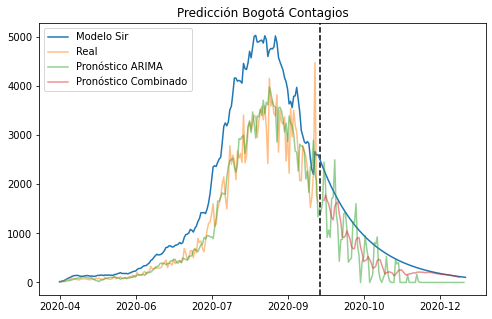

In [ ]:
# GRAFICA CONTAGIOS BOGOTÁ
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(bog.shape[0]-7, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=bog['fecha'].min()-datetime.timedelta(days=dias), end= bog['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m")
ax.tick_params(rotation = 0)
ax.plot(np.arange(len(c_sir)), c_sir, label = 'Modelo Sir')
ax.plot(np.arange(len(bog['bog_n']))[:-7], bog['bog_n'][:-7], alpha=0.5, label = 'Real')
ax.plot(np.arange(len(yhat1))[:-(df3.shape[0] - bog.index.max())], yhat1[df3.shape[0] - bog.index.max():], alpha=0.5, label='Pronóstico ARIMA')
ax.plot(np.arange(len(c_sir))[len(c_sir)-dias:-4], cont_prom_final, alpha=0.5, label='Pronóstico Combinado')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Bogotá Contagios');

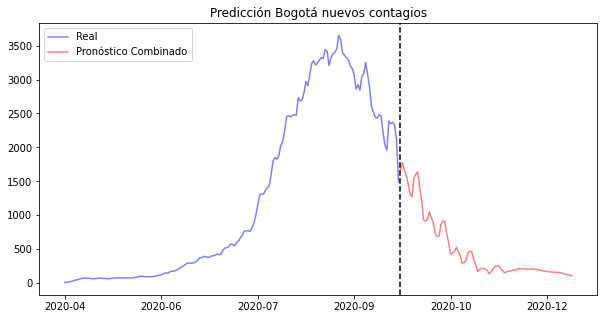

In [ ]:
# GRAFICA CONTAGIOS BOGOTÁ
rcParams['figure.figsize'] = 10,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(bog.shape[0]-4, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=bog['fecha'].min()-datetime.timedelta(days=dias), end= bog['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m")
ax.tick_params(rotation = 0)
ax.plot(np.arange(len(bog['bog_prom_n']))[:-4], bog['bog_prom_n'][:-4], alpha=0.5, label = 'Real', color ='Blue')
ax.plot(np.arange(len(c_sir))[len(c_sir)-dias:-4], cont_prom_final[:], alpha=0.5, label='Pronóstico Combinado', color = 'Red')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Bogotá nuevos contagios');
plt.savefig('img/bog1.png');

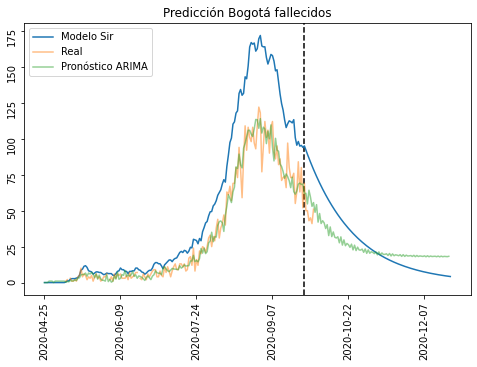

In [ ]:
# GRAFICA FALLECIDOS BOGOTÁ
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(bog.shape[0]-7, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=bog['fecha'].min()-datetime.timedelta(days=dias), end= bog['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m-%d")
ax.tick_params(rotation = 90)

ax.plot(np.arange(len(f_sir)), f_sir, label = 'Modelo Sir')
ax.plot(np.arange(len(bog['bog_f'])), bog['bog_f'], alpha=0.5, label = 'Real')
ax.plot(np.arange(len(yhat1_0))[:-(df3.shape[0] - bog.index.max())], yhat1_0[df3.shape[0] - bog.index.max():], alpha=0.5, label='Pronóstico ARIMA')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Bogotá fallecidos');

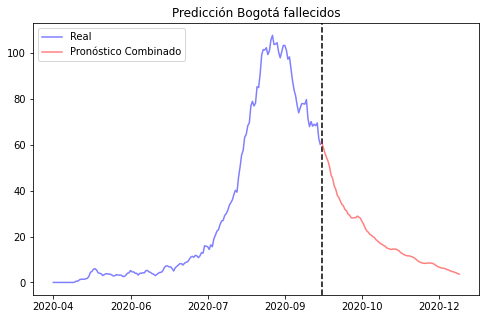

In [ ]:
# GRAFICA FALLECIDOS BOGOTÁ
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(bog.shape[0]-4, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=bog['fecha'].min()-datetime.timedelta(days=dias), end= bog['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m")
ax.tick_params(rotation = 0)
ax.plot(np.arange(len(bog['bog_prom_f']))[:-4], bog['bog_prom_f'][:-4], alpha=0.5, label = 'Real', color ='Blue')
ax.plot(np.arange(len(c_sir))[len(c_sir)-dias:-4], fall_prom_final[:], alpha=0.5, label='Pronóstico Combinado', color = 'Red')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Bogotá fallecidos');
plt.savefig('img/bog3.png');

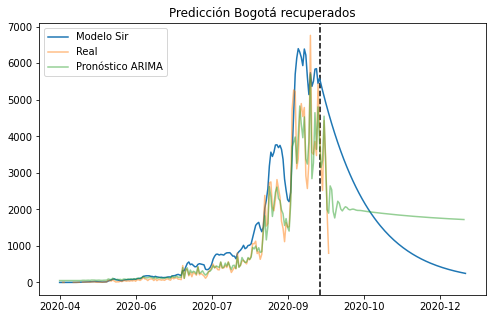

In [ ]:
# GRAFICA RUCUPERADOS BOGOTÁ
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(bog.shape[0]-7, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=bog['fecha'].min()-datetime.timedelta(days=dias), end= bog['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m")
ax.tick_params(rotation = 0)

ax.plot(np.arange(len(r_sir)), r_sir, label = 'Modelo Sir')
ax.plot(np.arange(len(bog['bog_r'])), bog['bog_r'], alpha=0.5, label = 'Real')
ax.plot(np.arange(len(yhat1_1))[:-(df3.shape[0] - bog.index.max())], yhat1_1[df3.shape[0] - bog.index.max():], alpha=0.5, label='Pronóstico ARIMA')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Bogotá recuperados');

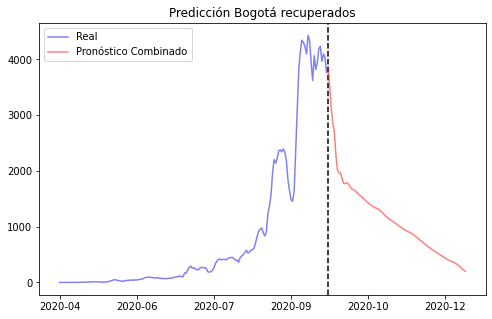

In [ ]:
# GRAFICA RECUPERADOS BOGOTÁ
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(bog.shape[0]-4, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=bog['fecha'].min()-datetime.timedelta(days=dias), end= bog['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m")
ax.tick_params(rotation = 0)
ax.plot(np.arange(len(bog['bog_prom_r']))[:-4], bog['bog_prom_r'][:-4], alpha=0.5, label = 'Real', color ='Blue')
ax.plot(np.arange(len(c_sir))[len(c_sir)-dias:-4], recu_prom_final[:], alpha=0.5, label='Pronóstico Combinado', color = 'Red')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Bogotá recuperados');
plt.savefig('img/bog2.png');

In [ ]:
# CODIGO ACTIVOS - CONFIRMADOS MEDELLIN
c = list(bog['bog_prom_n'][:-4]) + list(cont_prom_final[:])
f = list(bog['bog_prom_f'][:-4]) + list(fall_prom_final[:])
r = list(bog['bog_prom_r'][:-4]) + list(recu_prom_final[:])
acum_c = []
acum_f = []
acum_r = []
activos = []
ac_c = 0
ac_f = 0
ac_r = 0
act = 0
for i in range(len(c)):
  ac_c = ac_c + c[i]
  ac_f = ac_f + f[i]
  ac_r = ac_r + r[i]
  
  acum_c.append(ac_c)
  acum_f.append(ac_f)
  acum_r.append(ac_r)

  act = acum_c[i] - acum_f[i] - acum_r[i]
  activos.append(act)
activos = np.where(np.array(activos)<=0, 1, activos) # corrección de valores negativos

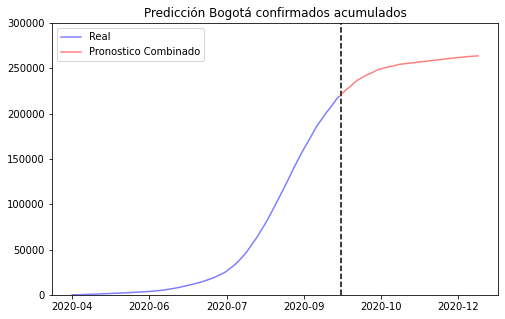

In [ ]:
# GRAFICA CONFIRMADOS BOGOTÁ
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(bog.shape[0]-4, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=bog['fecha'].min()-datetime.timedelta(days=dias), end= bog['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m")
ax.tick_params(rotation = 0)
ax.plot(np.arange(len(acum_c))[:-(len(acum_c)-(bog.shape[0]-4))], acum_c[:-(len(acum_c)-(bog.shape[0]-4))], alpha=0.5, label = 'Real', color ='Blue')
ax.plot(np.arange(len(acum_c))[(bog.shape[0]-4):], acum_c[(bog.shape[0]-4):], alpha=0.5, label = 'Pronostico Combinado', color ='Red')
ax.set_ylim(0, 300000)
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Bogotá confirmados acumulados');
#plt.savefig('img/bog4.png');

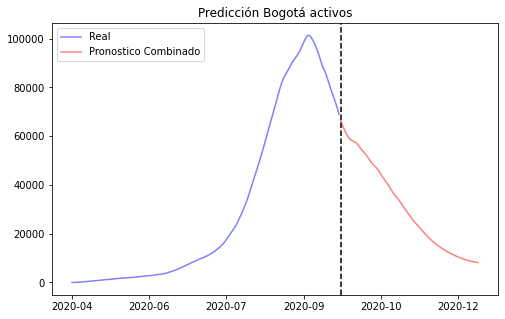

In [ ]:
# GRAFICA ACTIVOS BOGOTÁ
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(bog.shape[0]-4, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=bog['fecha'].min()-datetime.timedelta(days=dias), end= bog['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m")
ax.tick_params(rotation = 0)
ax.plot(np.arange(len(activos))[:-(len(acum_c)-(bog.shape[0]-4))], activos[:-(len(activos)-(bog.shape[0]-4))], alpha=0.5, label = 'Real', color ='Blue')
ax.plot(np.arange(len(activos))[(bog.shape[0]-4):], activos[(bog.shape[0]-4):], alpha=0.5, label = 'Pronostico Combinado', color ='Red')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Bogotá activos');
#plt.savefig('img/bog5.png');

In [ ]:
nprueba = ['Confirmados','Recuperados','Fallecidos','Activos']
w = bog['bog_prom_n'].sum()
h = bog['bog_prom_r'].sum()
g = bog['bog_prom_f'].sum()
cifra_bog = [round(w,).astype('int'), round(h,).astype('int'), round(g,).astype('int'), round(w-h-g,).astype('int')]
print(cifra_bog)
nue_bog = cont_prom_final[:7].astype('int')
rec_bog = recu_prom_final[:7].astype('int')
fal_bog = fall_prom_final[:7].astype('int')

[222963, 157759, 5680, 59524]


## Medellín

In [ ]:
# MODELO SIR MEDELLÍN

index = df3[df3['med_ca']>=50]['med_ca'].index.min() # corto la serie donde minimo se hayan confirmado 50 casos
med = df3.iloc[index:,:][['fecha','med_n','med_f','med_r','med_a','med_ca', 'med_ra','med_fa','med_prom_n','med_prom_a','med_prom_f','med_prom_r','med_ant_a','med_tasa_c','med_tasa_r','med_tasa_f']].reset_index().drop('index',axis = 1) 

# inicializar listas
c_sir = []
r_sir = []
f_sir = []
s_sir = []
c_acum_sir =[]
dias = 90

y = 20
dias_tasa_c = y
dias_tasa_r = y
dias_tasa_f = y


for i in range((med.shape[0]+dias)):

  ## iniciar variables unica vez - semillas
  if i == 0:
    c_acum = med['med_a'].min() # casos confirmados
    a_ant= c_acum # casos activos igual a los confirmados
    p = poblacion[1]*0.2 # tomar población
    suceptibles = p - a_ant # casos suceptibles iniciales

  ## iniciar variables en cada iteración
  if i <= med.shape[0] - dias_tasa_f:
    tasa_c = med['med_tasa_c'][i]
    tasa_r = med['med_tasa_r'][i]
    tasa_f = med['med_tasa_f'][i]
  else:
    tasa_c = med['med_tasa_c'][med.shape[0]-dias_tasa_c]
    tasa_r = med['med_tasa_r'][med.shape[0]-dias_tasa_r]
    tasa_f = med['med_tasa_f'][med.shape[0]-dias_tasa_f]
  
  ## cálculo de variables:

  # cálculo de contagiados
  if c_acum >= p:
    contagiados = 1
  else:
    contagiados =  a_ant*tasa_c*(suceptibles/p)

  recuperados  = a_ant*tasa_r   # cálculo de recuperados
  fallecidos = a_ant*tasa_f     # cálculo de fallecidos
  activos = a_ant + contagiados - recuperados - fallecidos # cálculo de activos
  c_acum = c_acum + contagiados # cáculo de casos confirmados
  suceptibles = suceptibles - contagiados # cálculo de suceptibles

  ## agregar variables
  c_sir.append(contagiados)
  r_sir.append(recuperados)
  f_sir.append(fallecidos)
  s_sir.append(suceptibles)
  c_acum_sir.append(c_acum)

  # actualizar variable activos
  a_ant = activos

In [ ]:
# MODELOS CORTO PLAZO MEDELLIN

dias = 90 # tiempo a predecir

## MODELO MEDELLÍN CONTAGIOS
tiempo = list(df3['med_n'].replace(np.nan, 0).index)
serie = df3['med_n'].replace(np.nan, 0)

## dividir muestra
split_time = len(tiempo) - 7 # dias rezago información
time_train = tiempo[:split_time]
x_train = serie[:split_time]

# ARIMA 
p = 5
q = 4
s = 3
model = ARIMA(x_train, order=(p,s,q), trend = 'n')
model_fit = model.fit()
yhat2 = model_fit.predict(min(tiempo), max(tiempo)+dias)
yhat2 = np.where(yhat2<=0, 1, yhat2) # corrección de valores negativos
rmse2 = np.sqrt(mean_squared_error(x_train, yhat2[:-dias-7])) # cálcular error



## MODELO MEDELLIN FALLECIDOS
split_time = len(tiempo) - 3 # dias rezago información
serie = df3['med_f'].replace(np.nan, 0)
x_train = serie[:split_time] # serie de entrenamiento

# ARMA 
p = 14
q = 5
s = 0
model = ARIMA(x_train, order=(p,s,q), trend = 'c')
model_fit = model.fit()
yhat2_1 = model_fit.predict(min(tiempo), max(tiempo)+dias)
yhat2_1 = np.where(yhat2_1<=0, 1, yhat2_1) # corrección de valores negativos
rmse2_1 = np.sqrt(mean_squared_error(x_train, yhat2_1[:-dias-3])) # cálcular error



# MODELO MEDELLÍN RECUPERADOS
split_time = len(tiempo) - 0 # dias rezago información
serie = df3['med_r'].replace(np.nan, 0)
x_train = serie[:split_time] # serie de entrenamiento

# AR
lag = 1
model = AutoReg(x_train, lags= lag, trend = 'c')
model_fit = model.fit()
yhat2_2 = model_fit.predict(min(tiempo), max(tiempo)+dias)
yhat2_2 = np.where(yhat2_2<=0, 1, yhat2_2) # corrección de valores negativos
rmse2_2= np.sqrt(mean_squared_error(x_train[7:], yhat2_2[7:-dias])) # cálcular error

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood op

In [ ]:
# imprimir errores
print('RMSE nuevos casos contagiados Medellin:', round(rmse2,2))
print('RMSE nuevos casos fallecidos Medellin: ', round(rmse2_1,2))
print('RMSE nuevos casos recuperados Medellin:', round(rmse2_2,2))

RMSE nuevos casos contagiados Medellin: 104.31
RMSE nuevos casos fallecidos Medellin:  2.62
RMSE nuevos casos recuperados Medellin: 143.31


In [ ]:
# inicializar variables
factor = 0.5
dias = 94
split_time = len(tiempo) - 7 
cont_final = []
fall_final = []
recu_final = []

# ciclo para unir pronosticos
for i in range(dias):
  cy = yhat2[split_time:]
  fy = yhat2_1[split_time:]
  ry = yhat2_2[split_time:]
  csy = c_sir
  fsy = f_sir
  rsy = r_sir

  # combinación contagios
  cont_m = (1-((i*factor)/100))*cy[i]
  cont_sir = (1-((i*factor)/100))*csy[i]
  cont_final.append(cont_m + cont_sir)

  # combinación fallecidos
  fall_m = (1-((i*factor)/100))*fy[i]
  fall_sir = (1-((i*factor)/100))*fsy[i]
  fall_final.append(fall_m + fall_sir)

  # combinación recuperados
  recu_m = (1-((i*factor)/100))*ry[i]
  recu_sir = (1-((i*factor)/100))*rsy[i]
  recu_final.append(recu_m + recu_sir)

cont_prom_final = running_mean(cont_final, 5)
fall_prom_final = running_mean(fall_final, 5)
recu_prom_final = running_mean(recu_final, 5)

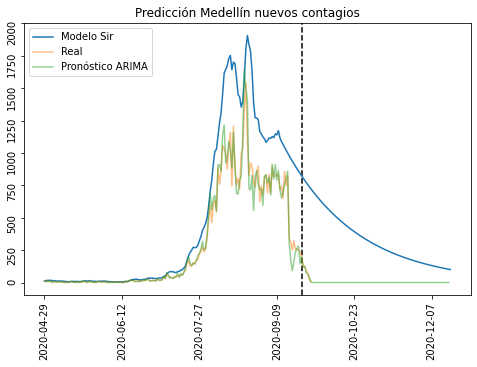

In [ ]:
# GRAFICA CONTAGIOS MEDELLÍN
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(med.shape[0]-7, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=med['fecha'].min()-datetime.timedelta(days=dias), end= med['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m-%d")
ax.tick_params(rotation = 90)
ax.plot(np.arange(len(c_sir)), c_sir, label = 'Modelo Sir')
ax.plot(np.arange(len(med['med_n'])), med['med_n'], alpha=0.5, label = 'Real')
ax.plot(np.arange(len(yhat2))[:-(df3.shape[0] - med.index.max())], yhat2[df3.shape[0] - med.index.max():], alpha=0.5, label='Pronóstico ARIMA')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Medellín nuevos contagios');

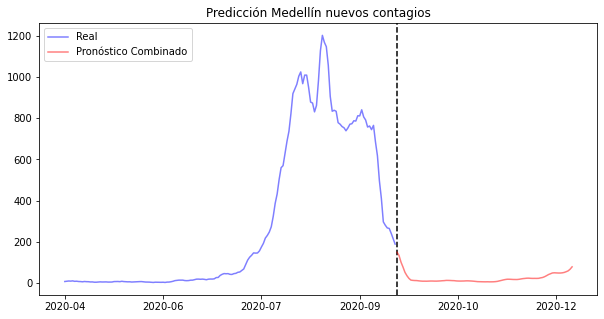

In [ ]:
# GRAFICA CONTAGIOS MEDELLÍN
rcParams['figure.figsize'] = 10,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(med.shape[0]-4, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=med['fecha'].min()-datetime.timedelta(days=dias), end= med['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m")
ax.tick_params(rotation = 0)
ax.plot(np.arange(len(med['med_prom_n']))[:-4], med['med_prom_n'][:-4], alpha=0.5, label = 'Real', color ='Blue')
ax.plot(np.arange(len(c_sir))[len(c_sir)-dias:-4], cont_prom_final[:], alpha=0.5, label='Pronóstico Combinado', color = 'Red')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Medellín nuevos contagios');
#plt.savefig('img/med1.png');

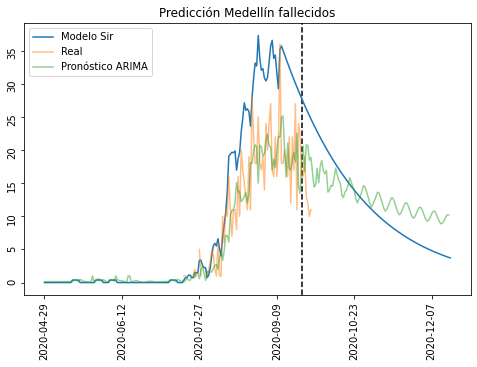

In [ ]:
# GRAFICA FALLECIDOS MEDELLÍN
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(med.shape[0]-7, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=med['fecha'].min()-datetime.timedelta(days=dias), end= med['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m-%d")
ax.tick_params(rotation = 90)
ax.plot(np.arange(len(f_sir)), f_sir, label = 'Modelo Sir')
ax.plot(np.arange(len(med['med_f'])), med['med_f'], alpha=0.5, label = 'Real')
ax.plot(np.arange(len(yhat2_1))[:-(df3.shape[0] - med.index.max())], yhat2_1[df3.shape[0] - med.index.max():], alpha=0.5, label='Pronóstico ARIMA')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Medellín fallecidos');

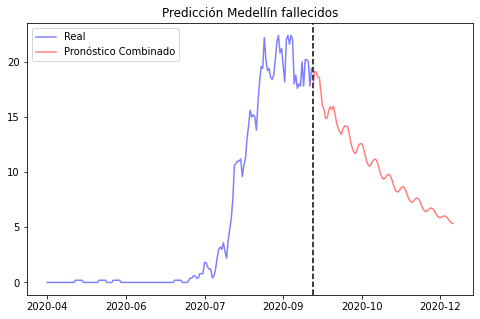

In [ ]:
# GRAFICA FALLECIDOS MEDELLÍN
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(med.shape[0]-4, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=med['fecha'].min()-datetime.timedelta(days=dias), end= med['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m")
ax.tick_params(rotation = 0)
ax.plot(np.arange(len(med['med_prom_f']))[:-4], med['med_prom_f'][:-4], alpha=0.5, label = 'Real', color ='Blue')
ax.plot(np.arange(len(c_sir))[len(c_sir)-dias:-4], fall_prom_final[:], alpha=0.5, label='Pronóstico Combinado', color = 'Red')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Medellín fallecidos');
#plt.savefig('img/med3.png');

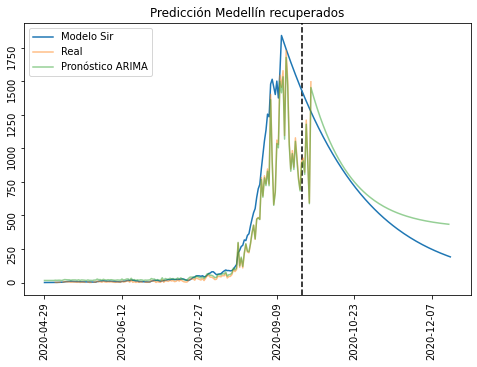

In [ ]:
# GRAFICA RECUPERADOS MEDELLÍN
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(med.shape[0]-7, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=med['fecha'].min()-datetime.timedelta(days=dias), end= med['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m-%d")
ax.tick_params(rotation = 90)
ax.plot(np.arange(len(r_sir)), r_sir, label = 'Modelo Sir')
ax.plot(np.arange(len(med['med_r'])), med['med_r'], alpha=0.5, label = 'Real')
ax.plot(np.arange(len(yhat2_2))[:-(df3.shape[0] - med.index.max())], yhat2_2[df3.shape[0] - med.index.max():], alpha=0.5, label='Pronóstico ARIMA')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Medellín recuperados');

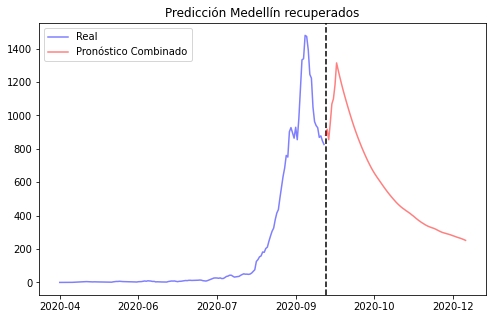

In [ ]:
# GRAFICA RECUPERADOS MEDELLÍN
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(med.shape[0]-4, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=med['fecha'].min()-datetime.timedelta(days=dias), end= med['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m")
ax.tick_params(rotation = 0)
ax.plot(np.arange(len(med['med_prom_r']))[:-4], med['med_prom_r'][:-4], alpha=0.5, label = 'Real', color ='Blue')
ax.plot(np.arange(len(c_sir))[len(c_sir)-dias:-4], recu_prom_final[:], alpha=0.5, label='Pronóstico Combinado', color = 'Red')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Medellín recuperados');
#plt.savefig('img/med2.png');

In [ ]:
# CODIGO ACTIVOS - CONFIRMADOS MEDELLIN
c = list(med['med_prom_n'][:-4]) + list(cont_prom_final[:])
f = list(med['med_prom_f'][:-4]) + list(fall_prom_final[:])
r = list(med['med_prom_r'][:-4]) + list(recu_prom_final[:])
acum_c = []
acum_f = []
acum_r = []
activos = []
ac_c = 0
ac_f = 0
ac_r = 0
act = 0
for i in range(len(c)):
  ac_c = ac_c + c[i]
  ac_f = ac_f + f[i]
  ac_r = ac_r + r[i]
  acum_c.append(ac_c)
  acum_f.append(ac_f)
  acum_r.append(ac_r)

  act = acum_c[i] - acum_f[i] - acum_r[i]
  activos.append(act)
activos = np.where(np.array(activos)<=0, 1, activos) # corrección de valores negativos

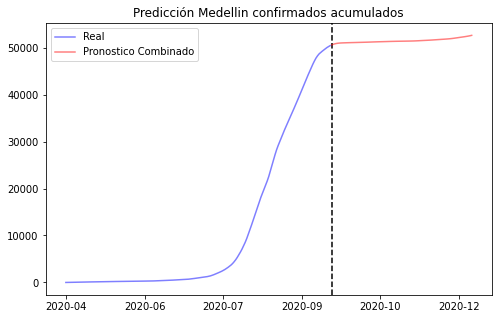

In [ ]:
# GRAFICA CONFIRMADOS MEDELLIN
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(med.shape[0]-4, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=med['fecha'].min()-datetime.timedelta(days=dias), end= med['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m")
ax.tick_params(rotation = 0)
ax.plot(np.arange(len(acum_c))[:-(len(acum_c)-(med.shape[0]-4))], acum_c[:-(len(acum_c)-(med.shape[0]-4))], alpha=0.5, label = 'Real', color ='Blue')
ax.plot(np.arange(len(acum_c))[(med.shape[0]-4):], acum_c[(med.shape[0]-4):], alpha=0.5, label = 'Pronostico Combinado', color ='Red')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Medellin confirmados acumulados');
#plt.savefig('img/med4.png');

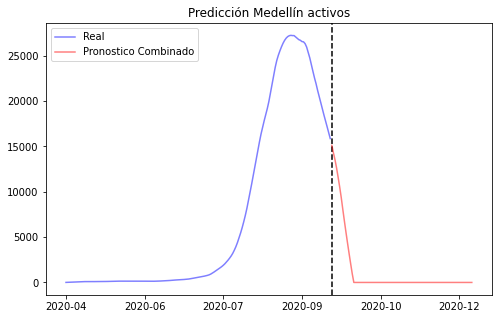

In [ ]:
# GRAFICA ACTIVOS MEDELLIN
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(med.shape[0]-4, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=med['fecha'].min()-datetime.timedelta(days=dias), end= med['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m")
ax.tick_params(rotation = 0)
ax.plot(np.arange(len(activos))[:-(len(acum_c)-(med.shape[0]-4))], activos[:-(len(activos)-(med.shape[0]-4))], alpha=0.5, label = 'Real', color ='Blue')
ax.plot(np.arange(len(activos))[(med.shape[0]-4):], activos[(med.shape[0]-4):], alpha=0.5, label = 'Pronostico Combinado', color ='Red')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Medellín activos');
#plt.savefig('img/med5.png');

In [ ]:
w = med['med_prom_n'].sum()
h = med['med_prom_r'].sum()
g = med['med_prom_f'].sum()
cifra_med = [round(w,).astype('int'), round(h,).astype('int'), round(g,).astype('int'), round(w-h-g,).astype('int')]
print(cifra_med)
nue_med = cont_prom_final[:7].astype('int')
rec_med = recu_prom_final[:7].astype('int')
fal_med = fall_prom_final[:7].astype('int')

[49855, 36353, 985, 12517]


## Barranquilla

In [ ]:
# MODELO SIR BARRANQUILLA
index = df3[df3['bar_ca']>=50]['bar_ca'].index.min() # corto la serie donde minimo se hayan confirmado 50 casos
bar = df3.iloc[index:,:][['fecha','bar_n','bar_f','bar_r','bar_a','bar_ca', 'bar_ra','bar_fa','bar_prom_n','bar_prom_a','bar_prom_f','bar_prom_r','bar_ant_a','bar_tasa_c','bar_tasa_r','bar_tasa_f']].reset_index().drop('index',axis = 1)

# inicializar listas
c_sir = []
r_sir = []
f_sir = []
s_sir = []
c_acum_sir =[]
dias = 90

dias_tasa_c = 30
dias_tasa_r = 30
dias_tasa_f = 30


for i in range((bar.shape[0]+dias)):

  ## iniciar variables unica vez - semillas
  if i == 0:
    c_acum = bar['bar_a'].min() # casos confirmados
    a_ant= c_acum # casos activos igual a los confirmados
    p = poblacion[2]*0.2 # tomar población
    suceptibles = p - a_ant # casos suceptibles iniciales

  ## iniciar variables en cada iteración
  if i <= bar.shape[0] - dias_tasa_f:
    tasa_c = bar['bar_tasa_c'][i]
    tasa_r = bar['bar_tasa_r'][i]
    tasa_f = bar['bar_tasa_f'][i]
  else:
    tasa_c = bar['bar_tasa_c'][bar.shape[0]-dias_tasa_c]
    tasa_r = bar['bar_tasa_r'][bar.shape[0]-dias_tasa_r]
    tasa_f = bar['bar_tasa_f'][bar.shape[0]-dias_tasa_f]
  
  ## cálculo de variables:

  # cálculo de contagiados
  if c_acum >= p:
    contagiados = 1
  else:
    contagiados =  a_ant*tasa_c*(suceptibles/p)

  recuperados  = a_ant*tasa_r   # cálculo de recuperados
  fallecidos = a_ant*tasa_f     # cálculo de fallecidos
  activos = a_ant + contagiados - recuperados - fallecidos # cálculo de activos
  c_acum = c_acum + contagiados # cáculo de casos confirmados
  suceptibles = suceptibles - contagiados # cálculo de suceptibles

  ## agregar variables
  c_sir.append(contagiados)
  r_sir.append(recuperados)
  f_sir.append(fallecidos)
  s_sir.append(suceptibles)
  c_acum_sir.append(c_acum)

  # actualizar variable activos
  a_ant = activos

In [ ]:
# MODELOS CORTO PLAZO BARRANQUILLA

dias = 90 # tiempo a predecir

## MODELO BARRANQUILLA CONTAGIOS
tiempo = list(df3['bar_n'].replace(np.nan, 0).index)
serie = df3['bar_n'].replace(np.nan, 0)

## dividir muestra
split_time = len(tiempo) - 7 # dias rezago información
time_train = tiempo[:split_time]
x_train = serie[:split_time]

# AR
lag=5
model = AutoReg(x_train, lags= lag, trend = 'ct')
model_fit = model.fit()
yhat3 = model_fit.predict(min(tiempo), max(tiempo)+dias)
yhat3 = np.where(yhat3<=0, 1, yhat3) # corrección de valores negativos
rmse3 = np.sqrt(mean_squared_error(x_train[lag:], yhat3[lag:-dias-7])) # cálcular error


## MODELO BARRANQUILLA FALLECIDOS
split_time = len(tiempo) - 3 # dias rezago información
serie = df3['bar_f'].replace(np.nan, 0)
x_train = serie[:split_time] # serie de entrenamiento

# AR
lag= 2
model = AutoReg(x_train, lags= lag, trend = 'ct')
model_fit = model.fit()
yhat3_1 = model_fit.predict(min(tiempo), max(tiempo)+dias)
yhat3_1 = np.where(yhat3_1<=0, 1, yhat3_1) # corrección de valores negativos
rmse3_1 = np.sqrt(mean_squared_error(x_train[lag:], yhat3_1[lag:-dias-3])) # cálcular error


# MODELO BARRANQUILLA RECUPERADOS
split_time = len(tiempo) - 0 # dias rezago información
serie = df3['bar_r'].replace(np.nan, 0)
x_train = serie[:split_time] # serie de entrenamiento

# ARIMA 
p = 13
q = 10
s = 1
model = ARIMA(x_train, order=(p,s,q), trend = 'c')
model_fit = model.fit()
yhat3_2 = model_fit.predict(min(tiempo), max(tiempo)+dias)
yhat3_2 = np.where(yhat3_2<=0, 1, yhat3_2) # corrección de valores negativos
rmse3_2 = np.sqrt(mean_squared_error(x_train[:], yhat3_2[:-dias])) # cálcular error

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/

In [ ]:
# imprimir errores
print('RMSE nuevos casos contagiados Barranquilla:', round(rmse3,2))
print('RMSE nuevos casos fallecidos Barranquilla: ', round(rmse3_1,2))
print('RMSE nuevos casos recuperados Barranquilla:', round(rmse3_2,2))

RMSE nuevos casos contagiados Barranquilla: 83.81
RMSE nuevos casos fallecidos Barranquilla:  3.49
RMSE nuevos casos recuperados Barranquilla: 105.93


In [ ]:
# inicializar variables
factor = 1
dias = 94
split_time = len(tiempo) - 7 
cont_final = []
fall_final = []
recu_final = []

# ciclo para unir pronosticos
for i in range(dias):
  cy = yhat3[split_time:]
  fy = yhat3_1[split_time:]
  ry = yhat3_2[split_time:]
  csy = c_sir
  fsy = f_sir
  rsy = r_sir

  # combinación contagios
  cont_m = (1-((i*factor)/100))*cy[i]
  cont_sir = (1-((i*factor)/100))*csy[i]
  cont_final.append(cont_m + cont_sir)

  # combinación fallecidos
  fall_m = (1-((i*factor)/100))*fy[i]
  fall_sir = (1-((i*factor)/100))*fsy[i]
  fall_final.append(fall_m + fall_sir)

  # combinación recuperados
  recu_m = (1-((i*factor)/100))*ry[i]
  recu_sir = (1-((i*factor)/100))*rsy[i]
  recu_final.append(recu_m + recu_sir)

cont_prom_final = running_mean(cont_final, 5)
fall_prom_final = running_mean(fall_final, 5)
recu_prom_final = running_mean(recu_final, 5)

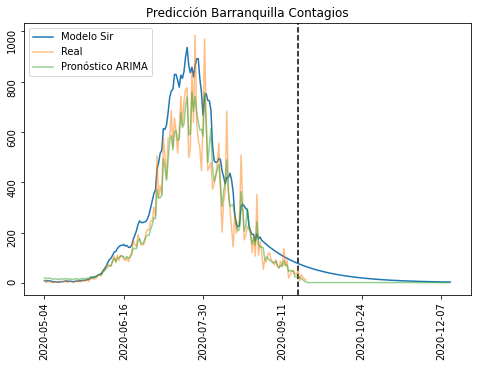

In [ ]:
# GRAFICA CONTAGIOS BARRANQUILLA
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(bar.shape[0]-7, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=bar['fecha'].min()-datetime.timedelta(days=dias), end= bar['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m-%d")
ax.tick_params(rotation = 90)
ax.plot(np.arange(len(c_sir)), c_sir, label = 'Modelo Sir')
ax.plot(np.arange(len(bar['bar_n'])), bar['bar_n'], alpha=0.5, label = 'Real')
ax.plot(np.arange(len(yhat3))[:-(df3.shape[0] - bar.index.max())], yhat3[df3.shape[0] - bar.index.max():], alpha=0.5, label='Pronóstico ARIMA')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Barranquilla Contagios');

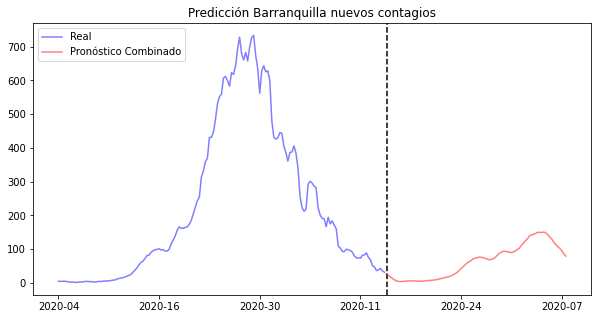

In [ ]:
# GRAFICA CONTAGIOS BARRANQUILLA
rcParams['figure.figsize'] = 10,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(bar.shape[0]-4, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=bar['fecha'].min()-datetime.timedelta(days=dias), end= bar['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%d")
ax.tick_params(rotation = 0)
ax.plot(np.arange(len(bar['bar_prom_n']))[:-4], bar['bar_prom_n'][:-4], alpha=0.5, label = 'Real', color ='Blue')
ax.plot(np.arange(len(c_sir))[len(c_sir)-dias:-4], cont_prom_final[:], alpha=0.5, label='Pronóstico Combinado', color = 'Red')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Barranquilla nuevos contagios');
#plt.savefig('img/bar1.png');

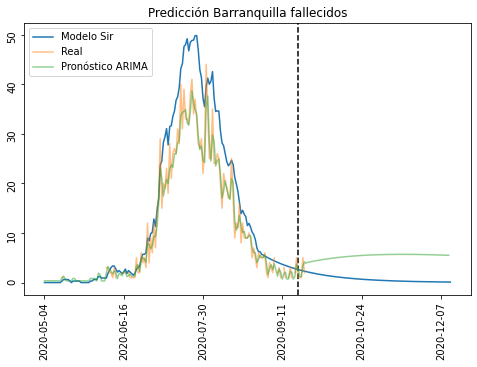

In [ ]:
# GRAFICA FALLECIDOS BARRANQUILLA
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(bar.shape[0]-7, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=bar['fecha'].min()-datetime.timedelta(days=dias), end= bar['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m-%d")
ax.tick_params(rotation = 90)
ax.plot(np.arange(len(f_sir)), f_sir, label = 'Modelo Sir')
ax.plot(np.arange(len(bar['bar_f'])), bar['bar_f'], alpha=0.5, label = 'Real')
ax.plot(np.arange(len(yhat3_1))[:-(df3.shape[0] - bar.index.max())], yhat3_1[df3.shape[0] - bar.index.max():], alpha=0.5, label='Pronóstico ARIMA')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Barranquilla fallecidos');

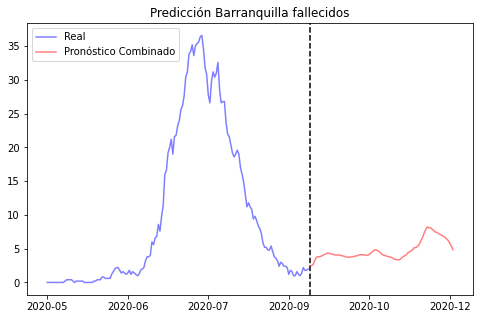

In [ ]:
# GRAFICA FALLECIDOS BARRANQUILLA
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(bar.shape[0]-4, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=bar['fecha'].min()-datetime.timedelta(days=dias), end= bar['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m")
ax.tick_params(rotation = 0)
ax.plot(np.arange(len(bar['bar_prom_f']))[:-4], bar['bar_prom_f'][:-4], alpha=0.5, label = 'Real', color ='Blue')
ax.plot(np.arange(len(c_sir))[len(c_sir)-dias:-4], fall_prom_final[:], alpha=0.5, label='Pronóstico Combinado', color = 'Red')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Barranquilla fallecidos');
#plt.savefig('img/bar3.png');

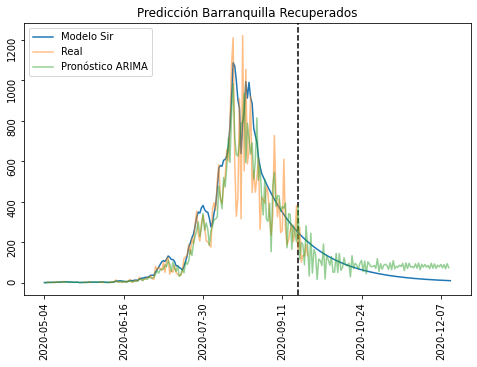

In [ ]:
# GRAFICA RECUPERADOS BARRANQUILLA
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(bar.shape[0]-7, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=bar['fecha'].min()-datetime.timedelta(days=dias), end= bar['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m-%d")
ax.tick_params(rotation = 90)
ax.plot(np.arange(len(r_sir)), r_sir, label = 'Modelo Sir')
ax.plot(np.arange(len(bar['bar_r'])), bar['bar_r'], alpha=0.5, label = 'Real')
ax.plot(np.arange(len(yhat3_2))[:-(df3.shape[0] - bar.index.max())], yhat3_2[df3.shape[0] - bar.index.max():], alpha=0.5, label='Pronóstico ARIMA')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Barranquilla Recuperados');

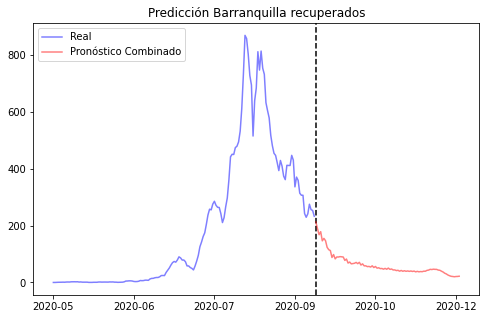

In [ ]:
# GRAFICA RECUPERADOS BARRANQUILLA
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(bar.shape[0]-4, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=bar['fecha'].min()-datetime.timedelta(days=dias), end= bar['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m")
ax.tick_params(rotation = 0)
ax.plot(np.arange(len(bar['bar_prom_r']))[:-4], bar['bar_prom_r'][:-4], alpha=0.5, label = 'Real', color ='Blue')
ax.plot(np.arange(len(c_sir))[len(c_sir)-dias:-4], recu_prom_final[:], alpha=0.5, label='Pronóstico Combinado', color = 'Red')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Barranquilla recuperados');
#plt.savefig('img/bar2.png');

In [ ]:
# CODIGO ACTIVOS - CONFIRMADOS BARRANQUILLA
c = list(bar['bar_prom_n'][:-4]) + list(cont_prom_final[:])
f = list(bar['bar_prom_f'][:-4]) + list(fall_prom_final[:])
r = list(bar['bar_prom_r'][:-4]) + list(recu_prom_final[:])
acum_c = []
acum_f = []
acum_r = []
activos = []
ac_c = 0
ac_f = 0
ac_r = 0
act = 0
for i in range(len(c)):
  ac_c = ac_c + c[i]
  ac_f = ac_f + f[i]
  ac_r = ac_r + r[i]
  acum_c.append(ac_c)
  acum_f.append(ac_f)
  acum_r.append(ac_r)

  act = acum_c[i] - acum_f[i] - acum_r[i]
  activos.append(act)
activos = np.where(np.array(activos)<=0, 1, activos) # corrección de valores negativos

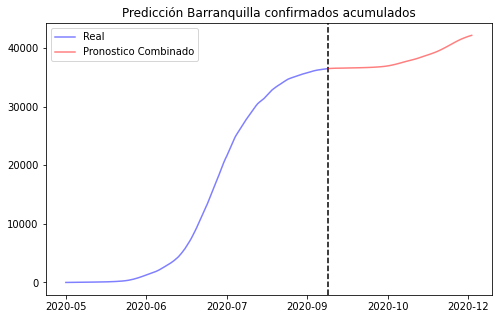

In [ ]:
# GRAFICA CONFIRMADOS BARRANQUILLA
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(bar.shape[0]-4, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=bar['fecha'].min()-datetime.timedelta(days=dias), end= bar['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m")
ax.tick_params(rotation = 0)
ax.plot(np.arange(len(acum_c))[:-(len(acum_c)-(bar.shape[0]-4))], acum_c[:-(len(acum_c)-(bar.shape[0]-4))], alpha=0.5, label = 'Real', color ='Blue')
ax.plot(np.arange(len(acum_c))[(bar.shape[0]-4):], acum_c[(bar.shape[0]-4):], alpha=0.5, label = 'Pronostico Combinado', color ='Red')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Barranquilla confirmados acumulados');
#plt.savefig('img/bar4.png');

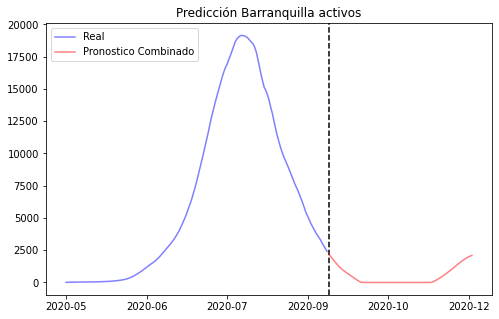

In [ ]:
# GRAFICA ACTIVOS BARRANQUILLA
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(bar.shape[0]-4, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=bar['fecha'].min()-datetime.timedelta(days=dias), end= bar['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m")
ax.tick_params(rotation = 0)
ax.plot(np.arange(len(activos))[:-(len(acum_c)-(bar.shape[0]-4))], activos[:-(len(activos)-(bar.shape[0]-4))], alpha=0.5, label = 'Real', color ='Blue')
ax.plot(np.arange(len(activos))[(bar.shape[0]-4):], activos[(bar.shape[0]-4):], alpha=0.5, label = 'Pronostico Combinado', color ='Red')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Barranquilla activos');
#plt.savefig('img/bar5.png');

In [ ]:
w = bar['bar_prom_n'].sum()
h = bar['bar_prom_r'].sum()
g = bar['bar_prom_f'].sum()
cifra_bar = [round(w,).astype('int'), round(h,).astype('int'), round(g,).astype('int'), round(w-h-g,).astype('int')]
print(cifra_bar)
nue_bar = cont_prom_final[:7].astype('int')
rec_bar = recu_prom_final[:7].astype('int')
fal_bar = fall_prom_final[:7].astype('int')

[36559, 33116, 1624, 1819]


## Cartagena

In [ ]:
# MODELO SIR CARTAGENA
index = df3[df3['car_ca']>=50]['car_ca'].index.min() # corto la serie donde minimo se hayan confirmado 50 casos
car = df3.iloc[index:,:][['fecha','car_n','car_f','car_r','car_a','car_ca', 'car_ra','car_fa','car_prom_n','car_prom_a','car_prom_f','car_prom_r','car_ant_a','car_tasa_c','car_tasa_r','car_tasa_f']].reset_index().drop('index',axis = 1)

# inicializar listas
c_sir = []
r_sir = []
f_sir = []
s_sir = []
c_acum_sir =[]
dias = 90

y= 30
dias_tasa_c = y
dias_tasa_r = y
dias_tasa_f = y


for i in range((car.shape[0]+dias)):

  ## iniciar variables unica vez - semillas
  if i == 0:
    c_acum = car['car_a'].min() # casos confirmados
    a_ant= c_acum # casos activos igual a los confirmados
    p = poblacion[3]*0.2 # tomar población
    suceptibles = p - a_ant # casos suceptibles iniciales

  ## iniciar variables en cada iteración
  if i <= car.shape[0] - dias_tasa_f:
    tasa_c = car['car_tasa_c'][i]
    tasa_r = car['car_tasa_r'][i]
    tasa_f = car['car_tasa_f'][i]
  else:
    tasa_c = car['car_tasa_c'][car.shape[0]-dias_tasa_c]
    tasa_r = car['car_tasa_r'][car.shape[0]-dias_tasa_r]
    tasa_f = car['car_tasa_f'][car.shape[0]-dias_tasa_f]
  
  ## cálculo de variables:

  # cálculo de contagiados
  if c_acum >= p:
    contagiados = 1
  else:
    contagiados =  a_ant*tasa_c*(suceptibles/p)

  recuperados  = a_ant*tasa_r   # cálculo de recuperados
  fallecidos = a_ant*tasa_f     # cálculo de fallecidos
  activos = a_ant + contagiados - recuperados - fallecidos # cálculo de activos
  c_acum = c_acum + contagiados # cáculo de casos confirmados
  suceptibles = suceptibles - contagiados # cálculo de suceptibles

  ## agregar variables
  c_sir.append(contagiados)
  r_sir.append(recuperados)
  f_sir.append(fallecidos)
  s_sir.append(suceptibles)
  c_acum_sir.append(c_acum)

  # actualizar variable activos
  a_ant = activos

In [ ]:
# MODELOS CORTO PLAZO CARTAGENA

dias = 90 # tiempo a predecir

## MODELO CARTAGENA CONTAGIOS
tiempo = list(df3['car_n'].replace(np.nan, 0).index)
serie = df3['car_n'].replace(np.nan, 0)

## dividir muestra
split_time = len(tiempo) - 7 # dias rezago información
time_train = tiempo[:split_time]
x_train = serie[:split_time]

# ARMA 
p = 8
q = 15
s = 0
model = ARIMA(x_train, order=(p,s,q), trend = 'n')
model_fit = model.fit()
yhat4 = model_fit.predict(min(tiempo), max(tiempo)+dias)
yhat4 = np.where(yhat4<=0, 1, yhat4) # corrección de valores negativos
rmse4 = np.sqrt(mean_squared_error(x_train[:], yhat4[:-dias-7])) # cálcular error


## MODELO CARTAGENA FALLECIDOS
split_time = len(tiempo) - 3 # dias rezago información
serie = df3['car_f'].replace(np.nan, 0)
x_train = serie[:split_time] # serie de entrenamiento

# ARMA 
p = 1
q = 7
s = 0
model = ARIMA(x_train, order=(p,s,q), trend = 'n')
model_fit = model.fit()
yhat4_1 = model_fit.predict(min(tiempo), max(tiempo)+dias)
yhat4_1 = np.where(yhat4_1<=0, 1, yhat4_1) # corrección de valores negativos
rmse4_1 = np.sqrt(mean_squared_error(x_train[:], yhat4_1[:-dias-3])) # cálcular error



# MODELO CARTAGENA RECUPERADOS
split_time = len(tiempo) - 0 # dias rezago información
serie = df3['car_r'].replace(np.nan, 0)
x_train = serie[:split_time] # serie de entrenamiento

# ARIMA 
p = 2
q = 7
s = 1
model = ARIMA(x_train, order=(p,s,q), trend = 'c')
model_fit = model.fit()
yhat4_2 = model_fit.predict(min(tiempo), max(tiempo)+dias)
yhat4_2 = np.where(yhat4_2<=0, 1, yhat4_2) # corrección de valores negativos
rmse4_2 = np.sqrt(mean_squared_error(x_train[:], yhat4_2[:-dias])) # cálcular error

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [ ]:
# imprimir errores
print('RMSE nuevos casos contagiados Cartagena:', round(rmse4,2))
print('RMSE nuevos casos fallecidos Cartagena: ', round(rmse4_1,2))
print('RMSE nuevos casos recuperados Cartagena:', round(rmse4_2,2))

RMSE nuevos casos contagiados Cartagena: 40.38
RMSE nuevos casos fallecidos Cartagena:  1.84
RMSE nuevos casos recuperados Cartagena: 50.83


In [ ]:
# inicializar variables
factor = 1
dias = 94
split_time = len(tiempo) - 7 
cont_final = []
fall_final = []
recu_final = []

# ciclo para unir pronosticos
for i in range(dias):
  cy = yhat4[split_time:]
  fy = yhat4_1[split_time:]
  ry = yhat4_2[split_time:]
  csy = c_sir
  fsy = f_sir
  rsy = r_sir

  # combinación contagios
  cont_m = (1-((i*factor)/100))*cy[i]
  cont_sir = (1-((i*factor)/100))*csy[i]
  cont_final.append(cont_m + cont_sir)

  # combinación fallecidos
  fall_m = (1-((i*factor)/100))*fy[i]
  fall_sir = (1-((i*factor)/100))*fsy[i]
  fall_final.append(fall_m + fall_sir)

  # combinación recuperados
  recu_m = (1-((i*factor)/100))*ry[i]
  recu_sir = (1-((i*factor)/100))*rsy[i]
  recu_final.append(recu_m + recu_sir)

cont_prom_final = running_mean(cont_final, 5)
fall_prom_final = running_mean(fall_final, 5)
recu_prom_final = running_mean(recu_final, 5)

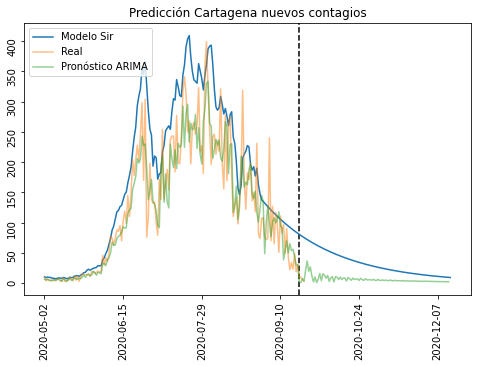

In [ ]:
# GRAFICA CONTAGIOS CARTAGENA
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(car.shape[0]-7, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=car['fecha'].min()-datetime.timedelta(days=dias), end= car['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m-%d")
ax.tick_params(rotation = 90)
ax.plot(np.arange(len(c_sir)), c_sir, label = 'Modelo Sir')
ax.plot(np.arange(len(car['car_n'])), car['car_n'], alpha=0.5, label = 'Real')
ax.plot(np.arange(len(yhat4))[:-(df3.shape[0] - car.index.max())], yhat4[df3.shape[0] - car.index.max():], alpha=0.5, label='Pronóstico ARIMA')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Cartagena nuevos contagios');

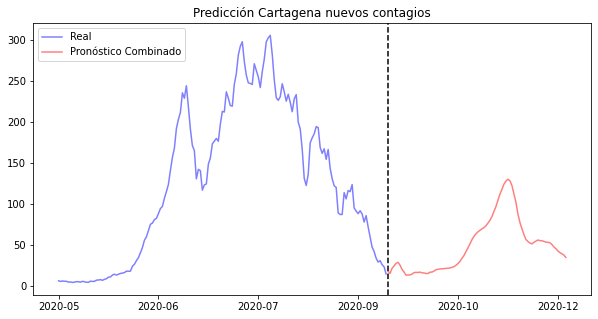

In [ ]:
# GRAFICA CONTAGIADOS CARTAGENA
rcParams['figure.figsize'] = 10,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(car.shape[0]-4, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=car['fecha'].min()-datetime.timedelta(days=dias), end= car['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m")
ax.tick_params(rotation = 0)
ax.plot(np.arange(len(car['car_prom_n']))[:-4], car['car_prom_n'][:-4], alpha=0.5, label = 'Real', color ='Blue')
ax.plot(np.arange(len(c_sir))[len(c_sir)-dias:-4], cont_prom_final[:], alpha=0.5, label='Pronóstico Combinado', color = 'Red')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Cartagena nuevos contagios');
#plt.savefig('img/car1.png');

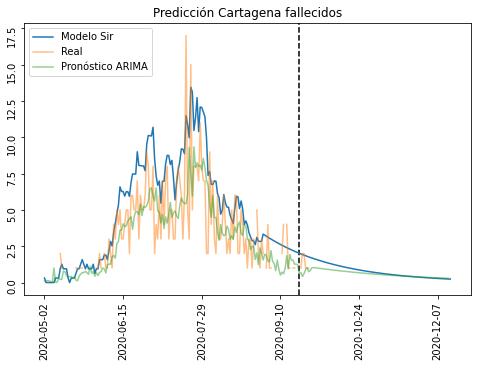

In [ ]:
# GRAFICA FALLECIDOS CARTAGENA
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(car.shape[0]-7, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=car['fecha'].min()-datetime.timedelta(days=dias), end= car['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m-%d")
ax.tick_params(rotation = 90)
ax.plot(np.arange(len(f_sir)), f_sir, label = 'Modelo Sir')
ax.plot(np.arange(len(car['car_f'])), car['car_f'], alpha=0.5, label = 'Real')
ax.plot(np.arange(len(yhat4_1))[:-(df3.shape[0] - car.index.max())], yhat4_1[df3.shape[0] - car.index.max():], alpha=0.5, label='Pronóstico ARIMA')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Cartagena fallecidos');

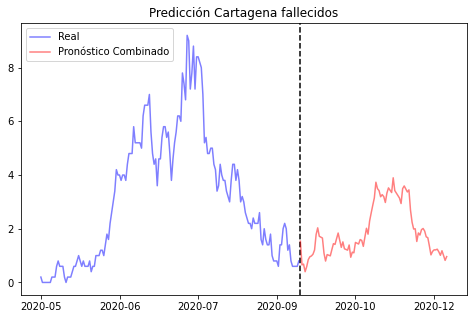

In [ ]:
# GRAFICA FALLECIDOS CARTAGENA
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(car.shape[0]-4, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=car['fecha'].min()-datetime.timedelta(days=dias), end= car['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m")
ax.tick_params(rotation = 0)
ax.plot(np.arange(len(car['car_prom_f']))[:-4], car['car_prom_f'][:-4], alpha=0.5, label = 'Real', color ='Blue')
ax.plot(np.arange(len(c_sir))[len(c_sir)-dias:], fall_final[:], alpha=0.5, label='Pronóstico Combinado', color = 'Red')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Cartagena fallecidos');
#plt.savefig('img/car3.png');

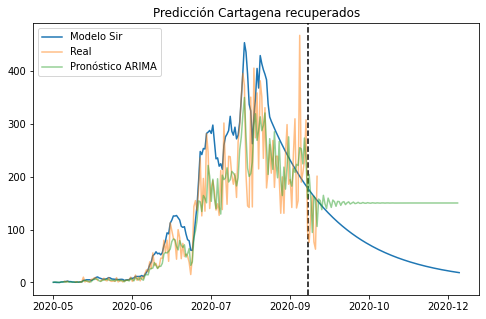

In [ ]:
# GRAFICA RECUPERADOS CARTAGENA
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(car.shape[0]-7, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=car['fecha'].min()-datetime.timedelta(days=dias), end= car['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m")
ax.tick_params(rotation = 0)
ax.plot(np.arange(len(r_sir)), r_sir, label = 'Modelo Sir')
ax.plot(np.arange(len(car['car_r'])), car['car_r'], alpha=0.5, label = 'Real')
ax.plot(np.arange(len(yhat4_2))[:-(df3.shape[0] - car.index.max())], yhat4_2[df3.shape[0] - car.index.max():], alpha=0.5, label='Pronóstico ARIMA')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Cartagena recuperados');

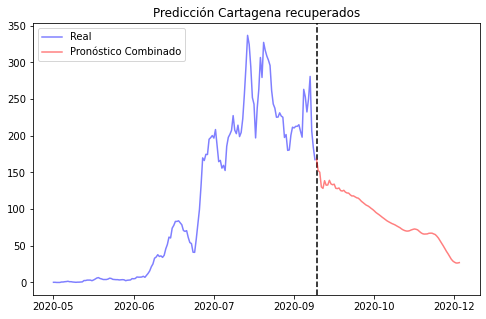

In [ ]:
# GRAFICA RECUPERADOS CARTAGENA
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(car.shape[0]-4, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=car['fecha'].min()-datetime.timedelta(days=dias), end= car['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m")
ax.tick_params(rotation = 0)
ax.plot(np.arange(len(car['car_prom_r']))[:-4], car['car_prom_r'][:-4], alpha=0.5, label = 'Real', color ='Blue')
ax.plot(np.arange(len(c_sir))[len(c_sir)-dias:-4], recu_prom_final[:], alpha=0.5, label='Pronóstico Combinado', color = 'Red')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Cartagena recuperados');
plt.savefig('img/car2.png');

In [ ]:
# CODIGO ACTIVOS - CONFIRMADOS CARTAGENA
c = list(car['car_prom_n'][:-4]) + list(cont_prom_final[:])
f = list(car['car_prom_f'][:-4]) + list(fall_prom_final[:])
r = list(car['car_prom_r'][:-4]) + list(recu_prom_final[:])
acum_c = []
acum_f = []
acum_r = []
activos = []
ac_c = 0
ac_f = 0
ac_r = 0
act = 0
for i in range(len(c)):
  ac_c = ac_c + c[i]
  ac_f = ac_f + f[i]
  ac_r = ac_r + r[i]
  acum_c.append(ac_c)
  acum_f.append(ac_f)
  acum_r.append(ac_r)

  act = acum_c[i] - acum_f[i] - acum_r[i]
  activos.append(act)
activos = np.where(np.array(activos)<=0, 1, activos) # corrección de valores negativos

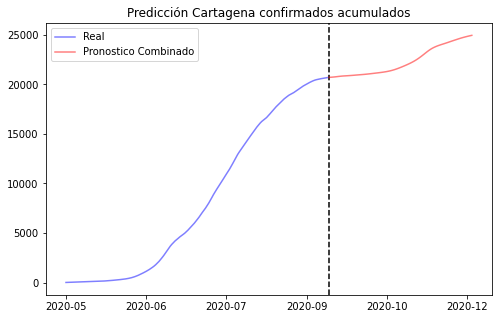

In [ ]:
# GRAFICA CONFIRMADOS CARTAGENA
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(car.shape[0]-4, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=car['fecha'].min()-datetime.timedelta(days=dias), end= car['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m")
ax.tick_params(rotation = 0)
ax.plot(np.arange(len(acum_c))[:-(len(acum_c)-(car.shape[0]-4))], acum_c[:-(len(acum_c)-(car.shape[0]-4))], alpha=0.5, label = 'Real', color ='Blue')
ax.plot(np.arange(len(acum_c))[(car.shape[0]-4):], acum_c[(car.shape[0]-4):], alpha=0.5, label = 'Pronostico Combinado', color ='Red')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Cartagena confirmados acumulados');
plt.savefig('img/car4.png');

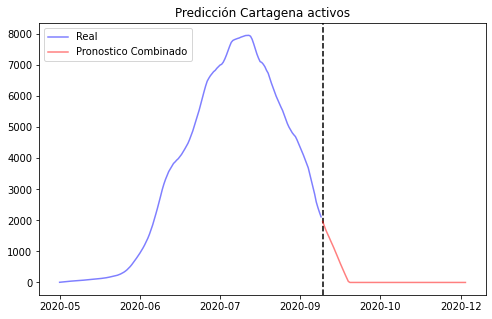

In [ ]:
# GRAFICA ACTIVOS CARTAGENA
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(car.shape[0]-4, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=car['fecha'].min()-datetime.timedelta(days=dias), end= car['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m")
ax.tick_params(rotation = 0)
ax.plot(np.arange(len(activos))[:-(len(acum_c)-(car.shape[0]-4))], activos[:-(len(activos)-(car.shape[0]-4))], alpha=0.5, label = 'Real', color ='Blue')
ax.plot(np.arange(len(activos))[(car.shape[0]-4):], activos[(car.shape[0]-4):], alpha=0.5, label = 'Pronostico Combinado', color ='Red')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Cartagena activos');
plt.savefig('img/car5.png');

In [ ]:
w = car['car_prom_n'].sum()
h = car['car_prom_r'].sum()
g = car['car_prom_f'].sum()
cifra_car = [round(w,).astype('int'), round(h,).astype('int'), round(g,).astype('int'), round(w-h-g,).astype('int')]
print(cifra_car)
nue_car = cont_prom_final[:7].astype('int')
rec_car = recu_prom_final[:7].astype('int')
fal_car = fall_prom_final[:7].astype('int')

[20720, 18542, 525, 1653]


## Cali

In [ ]:
# modelo sir Cali

index = df3[df3['cal_ca']>=50]['cal_ca'].index.min() # corto la serie donde minimo se hayan confirmado 50 casos
cal = df3.iloc[index:,:][['fecha','cal_n','cal_f','cal_r','cal_a','cal_ca', 'cal_ra','cal_fa','cal_prom_n','cal_prom_a','cal_prom_f','cal_prom_r','cal_ant_a','cal_tasa_c','cal_tasa_r','cal_tasa_f']].reset_index().drop('index',axis = 1)

# inicializar listas
c_sir = []
r_sir = []
f_sir = []
s_sir = []
c_acum_sir =[]
dias = 90

dias_tasa_c = 15
dias_tasa_r = 15
dias_tasa_f = 15


for i in range((cal.shape[0]+dias)):

  ## iniciar variables unica vez - semillas
  if i == 0:
    c_acum = cal['cal_a'].min() # casos confirmados
    a_ant= c_acum # casos activos igual a los confirmados
    p = poblacion[4]*0.2 # tomar población
    suceptibles = p - a_ant # casos suceptibles iniciales

  ## iniciar variables en cada iteración
  if i <= cal.shape[0] - dias_tasa_f:
    tasa_c = cal['cal_tasa_c'][i]
    tasa_r = cal['cal_tasa_r'][i]
    tasa_f = cal['cal_tasa_f'][i]
  else:
    tasa_c = cal['cal_tasa_c'][cal.shape[0]-dias_tasa_c]
    tasa_r = cal['cal_tasa_r'][cal.shape[0]-dias_tasa_r]
    tasa_f = cal['cal_tasa_f'][cal.shape[0]-dias_tasa_f]
  
  ## cálculo de variables:

  # cálculo de contagiados
  if c_acum >= p:
    contagiados = 1
  else:
    contagiados =  a_ant*tasa_c*(suceptibles/p)

  recuperados  = a_ant*tasa_r   # cálculo de recuperados
  fallecidos = a_ant*tasa_f     # cálculo de fallecidos
  activos = a_ant + contagiados - recuperados - fallecidos # cálculo de activos
  c_acum = c_acum + contagiados # cáculo de casos confirmados
  suceptibles = suceptibles - contagiados # cálculo de suceptibles

  ## agregar variables
  c_sir.append(contagiados)
  r_sir.append(recuperados)
  f_sir.append(fallecidos)
  s_sir.append(suceptibles)
  c_acum_sir.append(c_acum)

  # actualizar variable activos
  a_ant = activos

In [ ]:
# MODELOS CORTO PLAZO CALI

dias = 90 # tiempo a predecir

## MODELO CALI CONTAGIOS
tiempo = list(df3['cal_n'].replace(np.nan, 0).index)
serie = df3['cal_n'].replace(np.nan, 0)

## dividir muestra
split_time = len(tiempo) - 7 # dias rezago información
time_train = tiempo[:split_time]
x_train = serie[:split_time]

# ARMA 
p = 3
q = 5
s = 0
model = ARIMA(x_train, order=(p,s,q), trend = 'c')
model_fit = model.fit()
yhat5 = model_fit.predict(min(tiempo), max(tiempo)+dias)
yhat5 = np.where(yhat5<=0, 1, yhat5) # corrección de valores negativos
rmse5 = np.sqrt(mean_squared_error(x_train[:], yhat5[:-dias-7])) # cálcular error


## MODELO CALI FALLECIDOS
split_time = len(tiempo) - 3 # dias rezago información
serie = df3['cal_f'].replace(np.nan, 0)
x_train = serie[:split_time] # serie de entrenamiento

# ARMA 
p = 3
q = 5
s = 0
model = ARIMA(x_train, order=(p,s,q), trend = 'c')
model_fit = model.fit()
yhat5_1 = model_fit.predict(min(tiempo), max(tiempo)+dias)
yhat5_1 = np.where(yhat5_1<=0, 1, yhat5_1) # corrección de valores negativos
rmse5_1 = np.sqrt(mean_squared_error(x_train[:], yhat5_1[:-dias-3])) # cálcular error


# MODELO CALI RECUPERADOS
split_time = len(tiempo) - 0 # dias rezago información
serie = df3['cal_r'].replace(np.nan, 0)
x_train = serie[:split_time] # serie de entrenamiento

#ARMA
p = 4
q = 7
s = 0
model = ARIMA(x_train, order=(p,s,q), trend = 'c')
model_fit = model.fit()
yhat5_2 = model_fit.predict(min(tiempo), max(tiempo)+dias)
yhat5_2 = np.where(yhat5_2<=0, 1, yhat5_2) # corrección de valores negativos
rmse5_2 = np.sqrt(mean_squared_error(x_train[:], yhat5_2[:-dias])) # cálcular error

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [ ]:
# imprimir errores
print('RMSE nuevos casos contagiados Cali:', rmse5)
print('RMSE nuevos casos fallecidos Cali: ', rmse5_1)
print('RMSE nuevos casos recuperados Cali:', rmse5_2)

RMSE nuevos casos contagiados Cali: 50.15441710552951
RMSE nuevos casos fallecidos Cali:  2.5609237302143906
RMSE nuevos casos recuperados Cali: 111.22570209311488


In [ ]:
# inicializar variables
factor = 1
dias = 94
split_time = len(tiempo) - 7 
cont_final = []
fall_final = []
recu_final = []

# ciclo para unir pronosticos
for i in range(dias):
  cy = yhat5[split_time:]
  fy = yhat5_1[split_time:]
  ry = yhat5_2[split_time:]
  csy = c_sir
  fsy = f_sir
  rsy = r_sir

  # combinación contagios
  cont_m = (1-((i*factor)/100))*cy[i]
  cont_sir = (1-((i*factor)/100))*csy[i]
  cont_final.append(cont_m + cont_sir)

  # combinación fallecidos
  fall_m = (1-((i*factor)/100))*fy[i]
  fall_sir = (1-((i*factor)/100))*fsy[i]
  fall_final.append(fall_m + fall_sir)

  # combinación recuperados
  recu_m = (1-((i*factor)/100))*ry[i]
  recu_sir = (1-((i*factor)/100))*rsy[i]
  recu_final.append(recu_m + recu_sir)

cont_prom_final = running_mean(cont_final, 5)
fall_prom_final = running_mean(fall_final, 5)
recu_prom_final = running_mean(recu_final, 5)

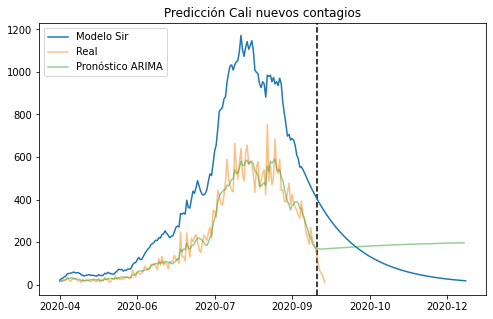

In [ ]:
# GRAFICA CONTAGIOS CALI
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(cal.shape[0]-7, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=cal['fecha'].min()-datetime.timedelta(days=dias), end= cal['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m")
ax.tick_params(rotation = 0)
ax.plot(np.arange(len(c_sir)), c_sir, label = 'Modelo Sir')
ax.plot(np.arange(len(cal['cal_n'])), cal['cal_n'], alpha=0.5, label = 'Real')
ax.plot(np.arange(len(yhat5))[:-(df3.shape[0] - cal.index.max())], yhat5[df3.shape[0] - cal.index.max():], alpha=0.5, label='Pronóstico ARIMA')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Cali nuevos contagios');

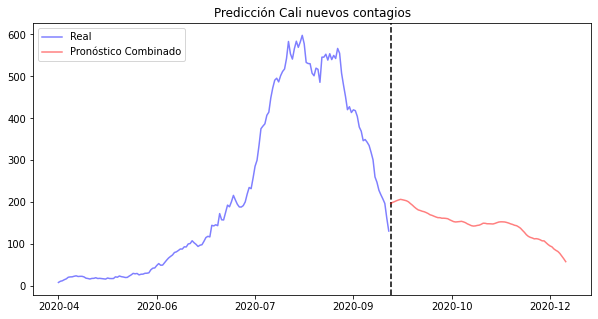

In [ ]:
# GRAFICA CONTAGIOS CALI
rcParams['figure.figsize'] = 10,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(cal.shape[0]-4, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=cal['fecha'].min()-datetime.timedelta(days=dias), end= cal['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m")
ax.tick_params(rotation = 0)
ax.plot(np.arange(len(cal['cal_prom_n']))[:-4], cal['cal_prom_n'][:-4], alpha=0.5, label = 'Real', color ='Blue')
ax.plot(np.arange(len(c_sir))[len(c_sir)-dias:-4], cont_prom_final[:], alpha=0.5, label='Pronóstico Combinado', color = 'Red')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Cali nuevos contagios');
plt.savefig('img/cal1.png');

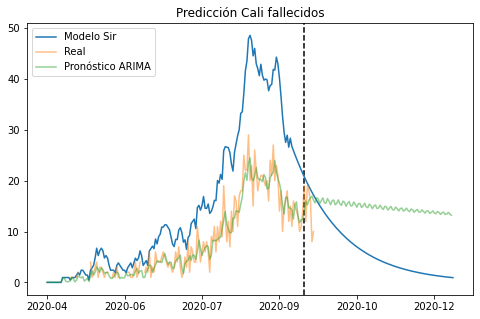

In [ ]:
# GRAFICA FALLECIDOS CALI
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(cal.shape[0]-7, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=cal['fecha'].min()-datetime.timedelta(days=dias), end= cal['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m")
ax.tick_params(rotation = 0)
ax.plot(np.arange(len(f_sir)), f_sir, label = 'Modelo Sir')
ax.plot(np.arange(len(cal['cal_f'])), cal['cal_f'], alpha=0.5, label = 'Real')
ax.plot(np.arange(len(yhat5_1))[:-(df3.shape[0] - cal.index.max())], yhat5_1[df3.shape[0] - cal.index.max():], alpha=0.5, label='Pronóstico ARIMA')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Cali fallecidos');

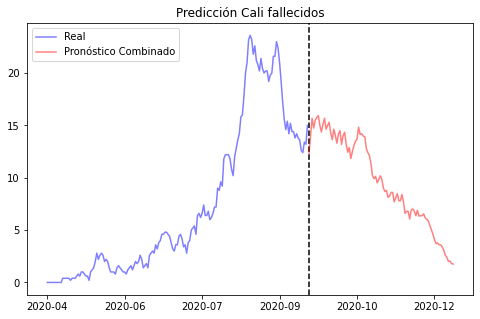

In [ ]:
# GRAFICA FALLECIDOS CALI
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(cal.shape[0]-4, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=cal['fecha'].min()-datetime.timedelta(days=dias), end= cal['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m")
ax.tick_params(rotation = 0)
ax.plot(np.arange(len(cal['cal_prom_f']))[:-4], cal['cal_prom_f'][:-4], alpha=0.5, label = 'Real', color ='Blue')
ax.plot(np.arange(len(c_sir))[len(c_sir)-dias:], fall_final[:], alpha=0.5, label='Pronóstico Combinado', color = 'Red')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Cali fallecidos');
plt.savefig('img/cal3.png');

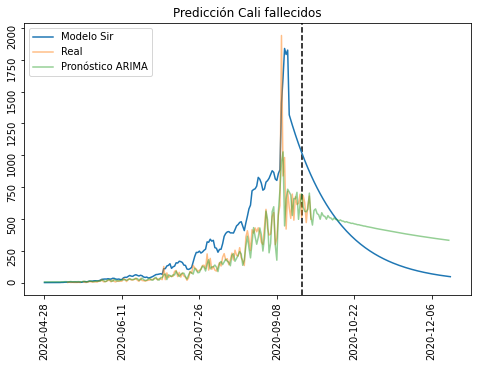

In [ ]:
# GRAFICA RECUPERADOS CALI
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(cal.shape[0]-7, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=cal['fecha'].min()-datetime.timedelta(days=dias), end= cal['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m-%d")
ax.tick_params(rotation = 90)
ax.plot(np.arange(len(r_sir)), r_sir, label = 'Modelo Sir')
ax.plot(np.arange(len(cal['cal_r'])), cal['cal_r'], alpha=0.5, label = 'Real')
ax.plot(np.arange(len(yhat5_2))[:-(df3.shape[0] - cal.index.max())], yhat5_2[df3.shape[0] - cal.index.max():], alpha=0.5, label='Pronóstico ARIMA')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Cali fallecidos');

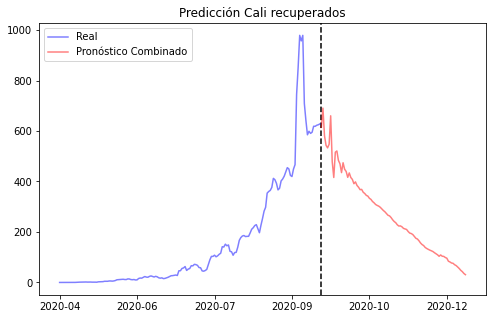

In [ ]:
# GRAFICA RECUPERADOS CALI
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(cal.shape[0]-4, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=cal['fecha'].min()-datetime.timedelta(days=dias), end= cal['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m")
ax.tick_params(rotation = 0)
ax.plot(np.arange(len(cal['cal_prom_r']))[:-4], cal['cal_prom_r'][:-4], alpha=0.5, label = 'Real', color ='Blue')
ax.plot(np.arange(len(c_sir))[len(c_sir)-dias:], recu_final[:], alpha=0.5, label='Pronóstico Combinado', color = 'Red')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Cali recuperados');
plt.savefig('img/cal2.png');

In [ ]:
# CODIGO ACTIVOS - CONFIRMADOS CALI
c = list(cal['cal_prom_n'][:-4]) + list(cont_prom_final[:])
f = list(cal['cal_prom_f'][:-4]) + list(fall_prom_final[:])
r = list(cal['cal_prom_r'][:-4]) + list(recu_prom_final[:])
acum_c = []
acum_f = []
acum_r = []
activos = []
ac_c = 0
ac_f = 0
ac_r = 0
act = 0
for i in range(len(c)):
  ac_c = ac_c + c[i]
  ac_f = ac_f + f[i]
  ac_r = ac_r + r[i]
  acum_c.append(ac_c)
  acum_f.append(ac_f)
  acum_r.append(ac_r)

  act = acum_c[i] - acum_f[i] - acum_r[i]
  activos.append(act)
activos = np.where(np.array(activos)<=0, 1, activos) # corrección de valores negativos

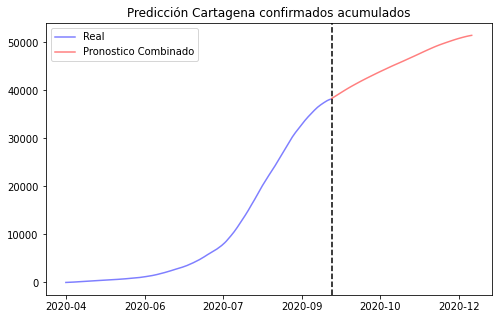

In [ ]:
# GRAFICA CONFIRMADOS CALI
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(cal.shape[0]-4, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=cal['fecha'].min()-datetime.timedelta(days=dias), end= cal['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m")
ax.tick_params(rotation = 0)
ax.plot(np.arange(len(acum_c))[:-(len(acum_c)-(cal.shape[0]-4))], acum_c[:-(len(acum_c)-(cal.shape[0]-4))], alpha=0.5, label = 'Real', color ='Blue')
ax.plot(np.arange(len(acum_c))[(cal.shape[0]-4):], acum_c[(cal.shape[0]-4):], alpha=0.5, label = 'Pronostico Combinado', color ='Red')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Cartagena confirmados acumulados');
plt.savefig('img/cal4.png');

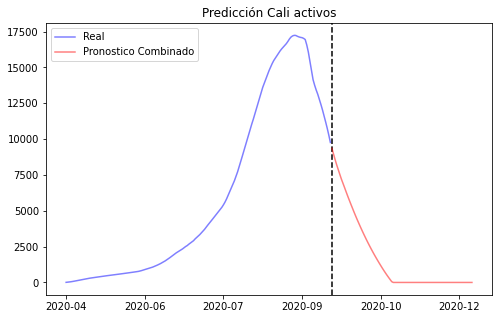

In [ ]:
# GRAFICA ACTIVOS CALI
rcParams['figure.figsize'] = 8,5
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
ax.axvline(cal.shape[0]-4, 0, 1, color = 'black', ls = '--')
x= pd.date_range(start=cal['fecha'].min()-datetime.timedelta(days=dias), end= car['fecha'].max(), periods = 7)+ datetime.timedelta(days=dias)
x= x.strftime("%Y-%m")
ax.tick_params(rotation = 0)
ax.plot(np.arange(len(activos))[:-(len(acum_c)-(cal.shape[0]-4))], activos[:-(len(activos)-(cal.shape[0]-4))], alpha=0.5, label = 'Real', color ='Blue')
ax.plot(np.arange(len(activos))[(cal.shape[0]-4):], activos[(cal.shape[0]-4):], alpha=0.5, label = 'Pronostico Combinado', color ='Red')
ax.set_xticklabels(x)
plt.legend(loc='upper left')
plt.title('Predicción Cali activos');
plt.savefig('img/cal5.png');

In [ ]:
w = cal['cal_prom_n'].sum()
h = cal['cal_prom_r'].sum()
g = cal['cal_prom_f'].sum()
cifra_cal = [round(w,).astype('int'), round(h,).astype('int'), round(g,).astype('int'), round(w-h-g,).astype('int')]
print(cifra_cal)
nue_cal = cont_prom_final[:7].astype('int')
rec_cal = recu_prom_final[:7].astype('int')
fal_cal = fall_prom_final[:7].astype('int')

[38413, 29500, 1312, 7600]


In [ ]:
temp = []
lista = [cifra_bog, cifra_med, cifra_bar, cifra_car, cifra_cal, nue_bog, rec_bog, fal_bog, nue_med, rec_med, fal_med,
         nue_bar, rec_bar, fal_bar, nue_car, rec_car, fal_car, nue_cal, rec_cal, fal_cal]
for i in lista:
  for j in i:
    temp.append("{:,}".format(j).replace(',','.'))

In [ ]:
cifra_bog2 = temp[0:4]
cifra_med2 = temp[4:8]
cifra_bar2 = temp[8:12]
cifra_car2 = temp[12:16]
cifra_cal2 = temp[16:20]

nue_bog2 = temp[20:27]
rec_bog2 = temp[27:34]
fal_bog2 = temp[34:41]
nue_med2 = temp[41:48]
rec_med2 = temp[48:55]
fal_med2 = temp[55:62]
nue_bar2 = temp[62:69]
rec_bar2 = temp[69:76]
fal_bar2 = temp[76:83]
nue_car2 = temp[83:90]
rec_car2 = temp[90:97]
fal_car2 = temp[97:104]
nue_cal2 = temp[104:111]
rec_cal2 = temp[111:118]
fal_cal2 = temp[118:]

In [ ]:
cifras_bog = list(zip(cifra_bog2,nprueba))
cifras_med = list(zip(cifra_med2,nprueba))
cifras_bar = list(zip(cifra_bar2,nprueba))
cifras_car = list(zip(cifra_car2,nprueba))
cifras_cal = list(zip(cifra_cal2,nprueba))

In [ ]:
fua = datetime.datetime.now(pytz.timezone('America/Bogota')).strftime("%Y-%m-%d")
fua

'2020-09-05'

# Carga Templates para reporte en HTML

In [ ]:
!cat templates/index.html
!cat templates/bar.html
!cat templates/car.html
!cat templates/cal.html
!cat templates/med.html

<!DOCTYPE html>
<html lang="en">

<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <meta http-equiv="X-UA-Compatible" content="ie=edge">
    <title>Dashboard Admin Template by Tooplate.com</title>
    <!--

    Template 2108 Dashboard

	http://www.tooplate.com/view/2108-dashboard

    -->
    <link rel="stylesheet" href="https://fonts.googleapis.com/css?family=Open+Sans:300,400,600">
    <!-- https://fonts.google.com/specimen/Open+Sans -->
    <link rel="stylesheet" href="css/fontawesome.min.css">
    <!-- https://fontawesome.com/ -->
    <link rel="stylesheet" href="css/fullcalendar.min.css">
    <!-- https://fullcalendar.io/ -->
    <link rel="stylesheet" href="css/bootstrap.min.css">
    <!-- https://getbootstrap.com/ -->
    <link rel="stylesheet" href="css/tooplate.css">

</head>

<body id="reportsPage">
    <div class="" id="home">
        <div class="container">
			<div class="row">
				<div class="col-12">
				<!--

# Exportar páginas finales con parámetros actualizados.

In [ ]:
from jinja2 import Template
## Carga el template almacenado como una cadena de texto
##
template = Template(open('templates/index.html', 'rt').read())
##
## Genera el archivo index.html pasando en la variable articles 
## de la plantilla, el conteido de la variable most_cited
##
open("index.html","w").write( template.render(fua = fua, cifras_bog = cifras_bog, nue_bog = nue_bog2, rec_bog = rec_bog2, fal_bog = fal_bog2))

16919

In [ ]:
from jinja2 import Template
## Carga el template almacenado como una cadena de texto
##
template = Template(open('templates/bar.html', 'rt').read())
##
## Genera el archivo index.html pasando en la variable articles 
## de la plantilla, el conteido de la variable most_cited
##
open("bar.html","w").write( template.render(fua = fua, cifras_bar = cifras_bar, nue_bar = nue_bar2, rec_bar = rec_bar2, fal_bar = fal_bar2))

16890

In [ ]:
from jinja2 import Template
## Carga el template almacenado como una cadena de texto
##
template = Template(open('templates/cal.html', 'rt').read())
##
## Genera el archivo index.html pasando en la variable articles 
## de la plantilla, el conteido de la variable most_cited
##
open("cal.html","w").write( template.render(fua = fua, cifras_cal = cifras_cal, nue_cal = nue_cal2, rec_cal = rec_cal2, fal_cal = fal_cal2))

16916

In [ ]:
from jinja2 import Template
## Carga el template almacenado como una cadena de texto
##
template = Template(open('templates/car.html', 'rt').read())
##
## Genera el archivo index.html pasando en la variable articles 
## de la plantilla, el conteido de la variable most_cited
##
open("car.html","w").write( template.render(fua = fua, cifras_car = cifras_car, nue_car = nue_car2, rec_car = rec_car2, fal_car = fal_car2))

16908

In [ ]:
from jinja2 import Template
## Carga el template almacenado como una cadena de texto
##
template = Template(open('templates/med.html', 'rt').read())
##
## Genera el archivo index.html pasando en la variable articles 
## de la plantilla, el conteido de la variable most_cited
##
open("med.html","w").write( template.render(fua = fua, cifras_med = cifras_med, nue_med = nue_med2, rec_med = rec_med2, fal_med = fal_med2))

16870